Loading data...
Selected the last 15000 rows for validation.
Applying feature engineering...
Feature engineering complete.
Columns after features: 53
Defining target variable...
Preparing data for modeling...
Handled NaNs. Dropped 185 rows.
Replacing 10 infinite values with NaN...
Dropped 10 rows after handling infinites.
Defining Features (X) and Binary Target (y)...
Final feature matrix shape: (14805, 49)
Target vector shape: (14805,)
Number of feature columns: 49

--- Starting Rolling Backtest with Regularization ---
Processed 50 predictions. Current Cumulative Accuracy: 0.6200
Processed 100 predictions. Current Cumulative Accuracy: 0.6300
Processed 150 predictions. Current Cumulative Accuracy: 0.6533
Processed 200 predictions. Current Cumulative Accuracy: 0.7000
Processed 250 predictions. Current Cumulative Accuracy: 0.6840
Processed 300 predictions. Current Cumulative Accuracy: 0.6700
Processed 350 predictions. Current Cumulative Accuracy: 0.6543
Processed 400 predictions. Current

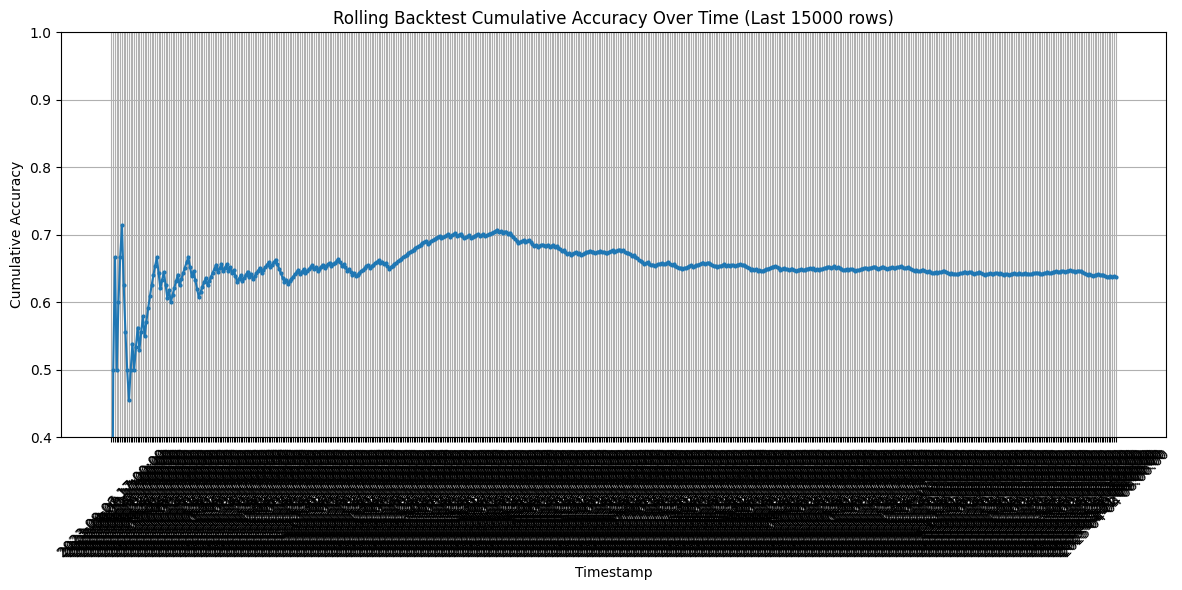

In [4]:
import pandas as pd
import numpy as np
import time
import os
import warnings
import traceback
from datetime import datetime

# Feature Engineering Imports
import pandas_ta as ta  # Technical indicators

# Modeling Imports
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation # <--- IMPORT CALLBACKS
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler # Needed for SVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid, StratifiedKFold # StratifiedKFold for stacking
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.pipeline import Pipeline # Optional: useful for SVM with scaling
from sklearn.impute import SimpleImputer # Better imputation strategy for pipeline

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore') # General suppression

# --- 1. Load Data and Select Last 15,000 Rows ---
print("Loading data...")
try:
    df_full = pd.read_csv('BTCUSDrec.csv')
    df_full = df_full.sort_values(by='unix', ascending=True).reset_index(drop=True)

    if len(df_full) < 10000:
        print(f"Warning: Full dataset has only {len(df_full)} rows. Using all available data.")
        df = df_full.copy()
    else:
        # Select the last 15,000 rows
        df = df_full.iloc[-15000:].reset_index(drop=True)
        print(f"Selected the last {len(df)} rows for validation.")

except FileNotFoundError:
    print("Error: BTCUSDrec.csv not found. Please make sure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred loading the data: {e}")
    exit()

# --- 2. Re-apply ALL Feature Engineering Steps ---
print("Applying feature engineering...")

# Basic Features
df['price_change_1h'] = df['close'].pct_change() * 100 # Note: Target will be recalculated later
df['price_range_pct'] = (df['high'] - df['low']) / df['close'] * 100
df['oc_change_pct'] = (df['close'] - df['open']) / df['open'] * 100

# Volatility Features
def garman_klass_volatility(open_, high, low, close, window):
    log_hl = np.log(high / low)
    log_co = np.log(close / open_)
    gk = 0.5 * (log_hl ** 2) - (2*np.log(2) - 1) * (log_co ** 2)
    rolling_mean = gk.rolling(window=window).mean()
    # Handle potential negative values in rolling_mean before sqrt
    rolling_mean = rolling_mean.clip(lower=0)
    return np.sqrt(rolling_mean)

def parkinson_volatility(high, low, window):
    log_hl_sq = np.log(high / low) ** 2
    rolling_sum = log_hl_sq.rolling(window=window).sum()
    factor = 1 / (4 * np.log(2) * window)
    return np.sqrt(factor * rolling_sum)

df['garman_klass_12h'] = garman_klass_volatility(df['open'], df['high'], df['low'], df['close'], window=12)
df['parkinson_3h'] = parkinson_volatility(df['high'], df['low'], window=3)

# Moving Averages & Standard Deviations
df['ma_3h'] = df['close'].rolling(window=3).mean()
df['rolling_std_3h'] = df['close'].rolling(window=3).std()

# Lagged Features (using the 1h price change calculated above)
df['price_return_1h_feat'] = df['close'].pct_change() # Use for lags, distinct from target col
lag_periods_price = [3, 6, 12, 24, 48, 72, 168]
for lag in lag_periods_price:
    df[f'lag_{lag}h_price_return'] = df['price_return_1h_feat'].shift(lag - 1) * 100 # Scale to %

df['volume_return_1h'] = df['Volume BTC'].pct_change() * 100
lag_periods_volume = [3, 6, 12, 24]
for lag in lag_periods_volume:
     df[f'lag_{lag}h_volume_return'] = df['volume_return_1h'].shift(lag - 1)

# Longer MAs and STDs
ma_periods = [6, 12, 24, 48, 72, 168]
for p in ma_periods:
    df[f'ma_{p}h'] = df['close'].rolling(window=p).mean()

std_periods = [6, 12, 24, 48, 72, 168]
for p in std_periods:
    # Std Dev on returns is more common than on price directly
    df[f'rolling_std_{p}h'] = df['price_return_1h_feat'].rolling(window=p).std() * 100 # Scale to %

# ATR
df['prev_close'] = df['close'].shift(1)
df['high_minus_low'] = df['high'] - df['low']
df['high_minus_prev_close'] = np.abs(df['high'] - df['prev_close'])
df['low_minus_prev_close'] = np.abs(df['low'] - df['prev_close'])
df['true_range'] = df[['high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close']].max(axis=1)
atr_periods = [14, 24, 48]
for p in atr_periods:
     df[f'atr_{p}h'] = df['true_range'].rolling(window=p).mean()
df = df.drop(columns=['prev_close', 'high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close', 'true_range'])

# Trend/Interaction Features
epsilon = 1e-9 # For safe division
for p in [24, 48, 168]:
    if f'ma_{p}h' in df.columns:
        df[f'close_div_ma_{p}h'] = df['close'] / (df[f'ma_{p}h'] + epsilon)

if 'ma_12h' in df.columns and 'ma_48h' in df.columns:
     df[f'ma12_div_ma48'] = df['ma_12h'] / (df['ma_48h'] + epsilon)
if 'ma_24h' in df.columns and 'ma_168h' in df.columns:
     df[f'ma24_div_ma168'] = df['ma_24h'] / (df['ma_168h'] + epsilon)
if 'rolling_std_12h' in df.columns and 'rolling_std_72h' in df.columns:
     df['std12_div_std72'] = df['rolling_std_12h'] / (df['rolling_std_72h'] + epsilon)
if 'price_range_pct' in df.columns:
    df['volume_btc_x_range'] = df['Volume BTC'] * df['price_range_pct']

# Non-linear Transformations
if 'rolling_std_3h' in df.columns:
    df['rolling_std_3h_sq'] = df['rolling_std_3h'] ** 2
if 'price_return_1h_feat' in df.columns:
    df['price_return_1h_sq'] = df['price_return_1h_feat'] ** 2 * 10000 # Scale %^2
if 'rolling_std_12h' in df.columns:
     df['rolling_std_12h_sqrt'] = np.sqrt(df['rolling_std_12h'].clip(lower=0) + epsilon) # Clip before sqrt

# Drop intermediate price return used for features
if 'price_return_1h_feat' in df.columns:
    df = df.drop(columns=['price_return_1h_feat'])

print("Feature engineering complete.")
print(f"Columns after features: {df.shape[1]}")


# --- 3. Define Target Variable ---
print("Defining target variable...")
df['price_change_12h'] = df['close'].shift(-12).sub(df['close']).div(df['close']).mul(100)
target_col = 'price_change_12h'


# --- 4. Prepare Data for Modeling (Handle NaNs, Select Features) ---
print("Preparing data for modeling...")

# Drop non-feature columns (Keep 'date'/'unix' for now for backtest indexing)
string_cols = df.select_dtypes(include=['object']).columns.tolist()
cols_to_drop = [col for col in string_cols if col != 'date'] # Keep date if exists
# Also drop the original 1h price change column if it wasn't the target
if 'price_change_1h' in df.columns and target_col != 'price_change_1h':
    cols_to_drop.append('price_change_1h')

df_model_ready = df.drop(columns=cols_to_drop)

# Handle NaNs introduced by feature engineering and target shifting
initial_rows = len(df_model_ready)
df_model_ready = df_model_ready.dropna() # Drop rows with ANY NaN
final_rows = len(df_model_ready)
print(f"Handled NaNs. Dropped {initial_rows - final_rows} rows.")

# Handle potential Infinite values just in case
numeric_cols = df_model_ready.select_dtypes(include=np.number).columns.tolist()
# Remove target col from numeric cols list before replacing inf
numeric_cols_no_target = [col for col in numeric_cols if col != target_col and col != 'unix'] # Keep unix out too
inf_count = np.isinf(df_model_ready[numeric_cols_no_target]).sum().sum()
if inf_count > 0:
    print(f"Replacing {inf_count} infinite values with NaN...")
    df_model_ready[numeric_cols_no_target] = df_model_ready[numeric_cols_no_target].replace([np.inf, -np.inf], np.nan)
    rows_before_inf_drop = len(df_model_ready)
    df_model_ready = df_model_ready.dropna()
    print(f"Dropped {rows_before_inf_drop - len(df_model_ready)} rows after handling infinites.")

# Define Features (X) and Binary Target (y)
print("Defining Features (X) and Binary Target (y)...")
feature_cols = [col for col in df_model_ready.columns if col not in [target_col, 'date', 'unix', 'symbol']] # Exclude identifiers and target
X = df_model_ready[feature_cols]
y_binary = (df_model_ready[target_col] > 0).astype(int) # Binary target: 1 if price increased, 0 otherwise

# Get timestamps for results
timestamps = df_model_ready['date'] if 'date' in df_model_ready else pd.to_datetime(df_model_ready['unix'], unit='ms')

print(f"Final feature matrix shape: {X.shape}")
print(f"Target vector shape: {y_binary.shape}")
print(f"Number of feature columns: {len(feature_cols)}")


# --- 5. Rolling Backtesting with Regularization ---
print("\n--- Starting Rolling Backtest with Regularization ---")

# Backtesting Parameters
initial_train_size = 1000  # Use first 1000 points for initial training
step_size = 24           # Retrain and predict every 24 hours
reg_alpha = 0.1          # L1 Regularization
reg_lambda = 0.1         # L2 Regularization
n_estimators = 100       # Number of trees
max_depth = 4            # Max depth of trees

if len(X) < initial_train_size + step_size:
     print("Error: Not enough data points after NaN handling for the specified initial_train_size.")
     exit()

# Store results
all_predictions = []
all_actual = []
all_probabilities = []
backtest_timestamps = []
cumulative_accuracy_list = []

# Loop through the data
num_predictions = 0
num_correct_predictions = 0

for i in range(initial_train_size, len(X), step_size):
    # Define train and test indices for this iteration
    train_idx_end = i
    test_idx = i # Predict the point at index i

    # Ensure test index does not go out of bounds
    if test_idx >= len(X):
        break

    # Get train and test sets for this fold
    X_train_roll = X.iloc[:train_idx_end]
    y_train_roll = y_binary.iloc[:train_idx_end]
    X_test_roll = X.iloc[test_idx:test_idx+1] # Test on the single next point
    y_test_roll_actual = y_binary.iloc[test_idx]
    current_timestamp = timestamps.iloc[test_idx]

    # Initialize and Train XGBoost Model with Regularization
    model_roll = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=0.1,
        objective='binary:logistic',
        eval_metric='logloss', # Common metric for binary classification
        use_label_encoder=False, # Recommended practice
        random_state=42,
        # --- Regularization Parameters ---
        reg_alpha=reg_alpha,   # L1 regularization term on weights
        reg_lambda=reg_lambda  # L2 regularization term on weights
    )

    model_roll.fit(X_train_roll, y_train_roll, verbose=False) # verbose=False to keep output clean

    # Make prediction
    pred_roll = model_roll.predict(X_test_roll)[0]
    prob_roll = model_roll.predict_proba(X_test_roll)[0, 1] # Probability of class 1 (increase)

    # Store results
    all_predictions.append(pred_roll)
    all_actual.append(y_test_roll_actual)
    all_probabilities.append(prob_roll)
    backtest_timestamps.append(current_timestamp)

    # Update cumulative accuracy
    num_predictions += 1
    if pred_roll == y_test_roll_actual:
        num_correct_predictions += 1
    cumulative_accuracy = num_correct_predictions / num_predictions
    cumulative_accuracy_list.append(cumulative_accuracy)

    # Print progress (optional)
    if num_predictions % 50 == 0:
         print(f"Processed {num_predictions} predictions. Current Cumulative Accuracy: {cumulative_accuracy:.4f}")

print(f"\nBacktesting finished. Made {num_predictions} predictions.")

# --- 6. Evaluate Backtesting Results ---
if num_predictions > 0:
    # Calculate final metrics
    final_accuracy = accuracy_score(all_actual, all_predictions)
    final_precision = precision_score(all_actual, all_predictions, zero_division=0)
    final_recall = recall_score(all_actual, all_predictions, zero_division=0)
    final_f1 = f1_score(all_actual, all_predictions, zero_division=0)

    print("\n--- Backtesting Performance Metrics ---")
    print(f"Overall Accuracy:  {final_accuracy:.4f}")
    print(f"Overall Precision: {final_precision:.4f}")
    print(f"Overall Recall:    {final_recall:.4f}")
    print(f"Overall F1 Score:  {final_f1:.4f}")

    # --- 7. Plot Cumulative Accuracy Over Time ---
    print("\nPlotting cumulative accuracy...")
    plt.figure(figsize=(12, 6))
    plt.plot(backtest_timestamps, cumulative_accuracy_list, marker='.', linestyle='-', markersize=4)
    plt.title(f'Rolling Backtest Cumulative Accuracy Over Time (Last {len(df)} rows)')
    plt.xlabel('Timestamp')
    plt.ylabel('Cumulative Accuracy')
    plt.ylim(0.4, 1.0) # Adjust ylim based on typical accuracy range (e.g., 0.4 to 0.8 or 1.0)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("No predictions were made, cannot evaluate performance or plot.")

What Now?

This is great progress! It tells you that predicting 12-hour direction is a much more promising path with your data and feature types.

Stick with the Simpler Structure (for now): Keep the single model (XGBoost) and the expanding window backtest for now.

Optimize This Setup:

Apply VIF: Now that you have a working model structure and a seemingly viable target, apply VIF filtering (e.g., threshold 5 or even your strict 1.69) to the features generated in this simpler script. Does reducing collinearity now improve the already decent results?

Tune Hyperparameters: Tune the XGBoost parameters (n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, subsample, colsample_bytree, min_child_weight) using a method like Optuna or RandomizedSearchCV within the rolling backtest loop (similar to how the meta-learner was tuned, but now for the single main model).

Experiment with Target Horizon: Is 12 hours optimal for the >0% target? Try 8 hours, 24 hours.

Experiment with Training Window: Does the expanding window work best, or would a large sliding window perform better for this target?

You've found a much better baseline. Now optimize it systematically!